## Step 1: Importing needed libraries for mathematical operations and data manipulation

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy

## Step 2: Defining types of players

In [57]:
def conservative_strategy(player):
        player["current_bet"] = player["base_bet"]
        
def martingale_strategy(player):
    if player["last_result"] == "loss":
        player["current_bet"] = min(player["current_bet"] * 2, player["balance"])
    else:
        player["current_bet"] = player["base_bet"]

def compulsive_gambler_strategy(player):
    player["current_bet"] = max(1, int(player["balance"] * 0.5))

players = {
    "Martingale Strategy": {
        "balance": 500,
        "base_bet": 10,
        "current_bet": 10,
        "last_result": "loss",
        "strategy": martingale_strategy
    },
    "Conservative": {
        "balance": 500,
        "base_bet": 10,
        "current_bet": 10,
        "last_result": "win",
        "strategy": conservative_strategy
    },
    "Compulsive Gambler": {
        "balance": 500,
        "base_bet": 20,
        "current_bet": 20,
        "last_result": "win",
        "strategy": compulsive_gambler_strategy
    }
}

## Step 3: Defining probabilities for roulette outcomes and results of spins

In [58]:
wheel = np.arange(37)
red = wheel[1::2]
black = wheel[2::2]
zero = np.array([wheel[0]])
probabilities = np.zeros_like(wheel, dtype=float)

for n in wheel:
    if n in red:
        probabilities[n] = 0.4864 / len(red)
    elif n in black:
        probabilities[n] = 0.4864 / len(black)
probabilities[0] = 1 - probabilities[red].sum() - probabilities[black].sum()
assert abs(sum(probabilities) - 1) < 1e-6

## Step 4: Simulating betting process

In [59]:
def round_wheel():
    return np.random.choice(wheel, p=probabilities)

def simulate_betting(players, max_bet=500):
    result = round_wheel()
    eliminated = []
    for name, player in list(players.items()):
        if player["balance"] > 0:
            if name == "Martingale Strategy":
                if player["balance"] < player["current_bet"]:
                    eliminated.append(name)
                    continue
                bet = player["current_bet"]
            else:
                bet = min(player["current_bet"], player["balance"])
            player["balance"] -= bet
            if result in red:
                player["balance"] += bet * 2
                player["last_result"] = "win"
            else:
                player["last_result"] = "loss"
            player["strategy"](player)
            player["current_bet"] = min(player["current_bet"], max_bet)
            if player["balance"] <= 0:
                eliminated.append(name)
    for name in eliminated:
        players[name]["balance"] = 0
        
def game_simulation(players):
    history = []
    history.append({name: player["balance"] for name, player in players.items()})
    while any(player["balance"] > 0 for player in players.values()):
        simulate_betting(players)
        round_balances = {name : player["balance"] for name, player in players.items()}
        history.append(round_balances)
    return pd.DataFrame(history)

all_games = []
for i in range(8):
    players_copy = copy.deepcopy(players)
    balance_history = game_simulation(players_copy)
    all_games.append(balance_history)

## Step 5: Plotting the results to showcase the difference between the strategies

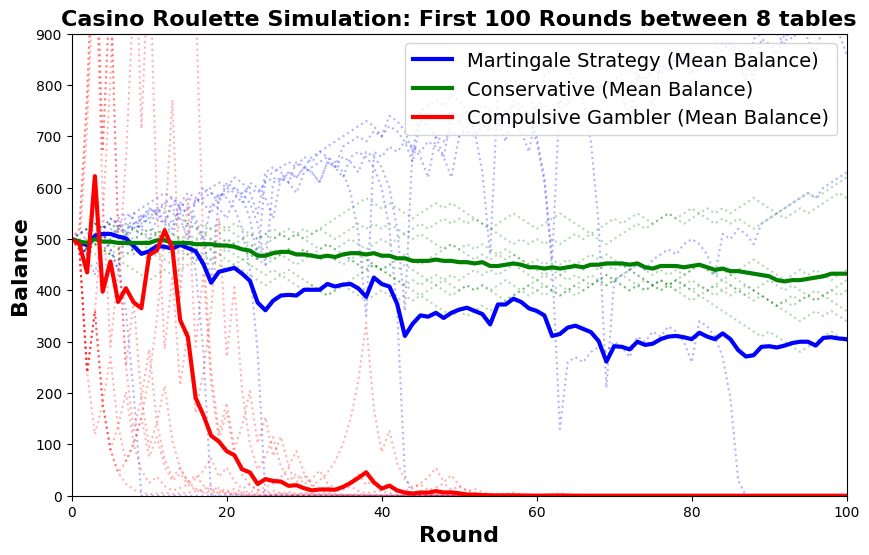

In [60]:
fig, ax = plt.subplots(figsize = (10, 6))
colors = {
    "Martingale Strategy": "blue",
    "Conservative": "green",
    "Compulsive Gambler": "red"
}
limit = 100
ax.set_xlim(0, limit)
ax.set_ylim(0, 900)

for game_data in all_games:
    truncated = game_data.iloc[:limit+1]
    for player in truncated.columns:
        series = truncated[player].dropna()
        ax.plot(series.index, series.values, color = colors[player], alpha = 0.3, linestyle = ":")

mean_handles = []
for player in colors.keys():
    all_player_data = [game[player].iloc[:limit + 1].values 
                       if player in game.columns 
                       else np.full(limit + 1, np.nan) for game in all_games]
    mean_balance = np.nanmean(all_player_data, axis = 0)
    mean_balance = np.nan_to_num(mean_balance, nan = 0.0)
    line, = ax.plot(range(limit + 1), mean_balance, color = colors[player], lw = 3, label = f"{player} (Mean Balance)")
    mean_handles.append(line)

ax.set_title("Casino Roulette Simulation: First 100 Rounds between 8 tables", fontsize = 16, fontweight = 'bold')
ax.set_xlabel("Round", fontsize = 16, fontweight = 'bold')
ax.set_ylabel("Balance", fontsize = 16, fontweight = 'bold')

ax.legend(handles = mean_handles, loc = "upper right", fontsize = 14)
plt.show()
